In [ ]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

Output streaming troncato alle ultime 5000 righe.
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.60.jpg  
  inflating: cats_and_dogs/train/dogs/dog.858.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.858.jpg  
  inflating: cats_and_dogs/train/dogs/dog.680.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.680.jpg  
  inflating: cats_and_dogs/train/dogs/dog.694.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.694.jpg  
  inflating: cats_and_dogs/train/dogs/dog.864.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.864.jpg  
  inflating: cats_and_dogs/train/dogs/dog.870.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.870.jpg  
  inflating: cats_and_dogs/train/dogs/dog.871.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.871.jpg  
  inflating: cats_and_dogs/train/dogs/dog.865.jpg  
  inflating: __MACOSX/cats_and_dogs/train/dogs/._dog.865.jpg  
  inflating: cats_and_dogs/train/dogs/dog.695.jpg  
  inflating: __MACOSX/cats_and_

**Cell 3**

Create image generators for each of the three image data sets (train, validation, test). Use ImageDataGenerator to read / decode the images and convert them into floating point tensors. Use the rescale argument (and no other arguments for now) to rescale the tensors from values between 0 and 255 to values between 0 and 1.

For the *_data_gen variables, use the flow_from_directory method. Pass in the batch size, directory, target size ((IMG_HEIGHT, IMG_WIDTH)), class mode, and anything else required. test_data_gen will be the trickiest one. For test_data_gen, make sure to pass in shuffle=False to the flow_from_directory method. This will make sure the final predictions stay is in the order that our test expects. For test_data_gen it will also be helpful to observe the directory structure.

In [ ]:
# 3
train_image_generator = ImageDataGenerator(rescale=1./255)
validation_image_generator = ImageDataGenerator(rescale=1./255)
test_image_generator = ImageDataGenerator(rescale=1./255)

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                              class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(batch_size=batch_size,
                                                         directory=PATH,
                                                         classes=['test'],
                                                         target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                         class_mode='input',
                                                         shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


**Cell 4**

The plotImages function will be used a few times to plot images. It takes an array of images and a probabilities list, although the probabilities list is optional. This code is given to you. If you created the train_data_gen variable correctly, then running this cell will plot five random training images.

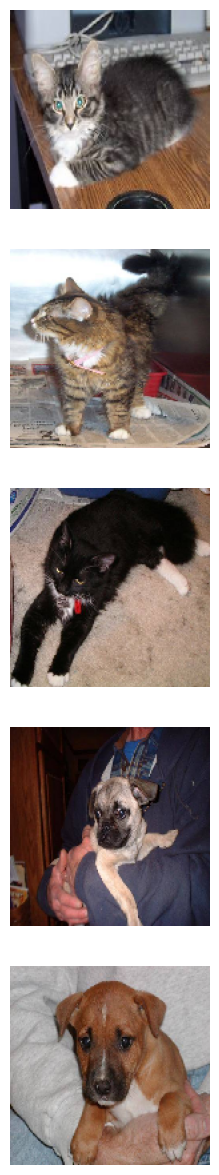

In [ ]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


**Cell 5**

Recreate the train_image_generator using ImageDataGenerator.

Since there are a small number of training examples, there is a risk of overfitting. One way to fix this problem is by creating more training data from existing training examples by using random transformations.

Add 4-6 random transformations as arguments to ImageDataGenerator. Make sure to rescale the same as before.

In [ ]:
# 5
train_image_generator = ImageDataGenerator(rescale=1./255, fill_mode="nearest",
                                           horizontal_flip=True, vertical_flip=True,
                                           width_shift_range=0.3, height_shift_range=0.3,
                                           shear_range=0.25, zoom_range=0.25)

**Cell 6**

You don't have to do anything for this cell. train_data_gen is created just like before but with the new train_image_generator. Then, a single image is plotted five different times using different variations.

Found 2000 images belonging to 2 classes.


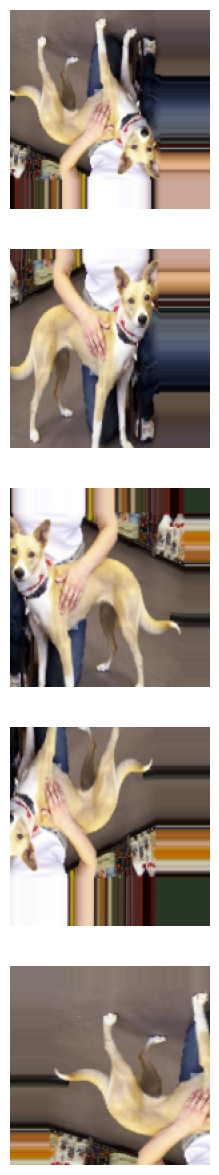

In [ ]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

**Cell 7**

In this cell, create a model for the neural network that outputs class probabilities. It should use the Keras Sequential model. It will probably involve a stack of Conv2D and MaxPooling2D layers and then a fully connected layer on top that is activated by a ReLU activation function.

Compile the model passing the arguments to set the optimizer and loss. Also pass in metrics=['accuracy'] to view training and validation accuracy for each training epoch.

In [ ]:
# 7
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Dense(2))

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

**Cell 8**

Use the fit method on your model to train the network. Make sure to pass in arguments for x, steps_per_epoch, epochs, validation_data, and validation_steps.

In [ ]:
# 8
history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size, epochs=epochs,
                    validation_data=val_data_gen, validation_steps=total_val // batch_size)

Epoch 1/15
15/15 [==============================] - 117s 8s/step - loss: 0.6299 - accuracy: 0.6394 - val_loss: 0.6000 - val_accuracy: 0.6596
Epoch 2/15
15/15 [==============================] - 119s 8s/step - loss: 0.6780 - accuracy: 0.5732 - val_loss: 0.6400 - val_accuracy: 0.6529
Epoch 3/15
15/15 [==============================] - 120s 8s/step - loss: 0.6770 - accuracy: 0.5759 - val_loss: 0.6593 - val_accuracy: 0.6261
Epoch 4/15
15/15 [==============================] - 117s 8s/step - loss: 0.6544 - accuracy: 0.6218 - val_loss: 0.6147 - val_accuracy: 0.6696
Epoch 5/15
15/15 [==============================] - 110s 7s/step - loss: 0.6530 - accuracy: 0.6143 - val_loss: 0.6595 - val_accuracy: 0.5748
Epoch 6/15
15/15 [==============================] - 117s 8s/step - loss: 0.6372 - accuracy: 0.6373 - val_loss: 0.5986 - val_accuracy: 0.6652
Epoch 7/15
15/15 [==============================] - 116s 8s/step - loss: 0.6229 - accuracy: 0.6410 - val_loss: 0.5961 - val_accuracy: 0.6551
Epoch 8/15
15

**Cell 9**

Run this cell to visualize the accuracy and loss of the model.

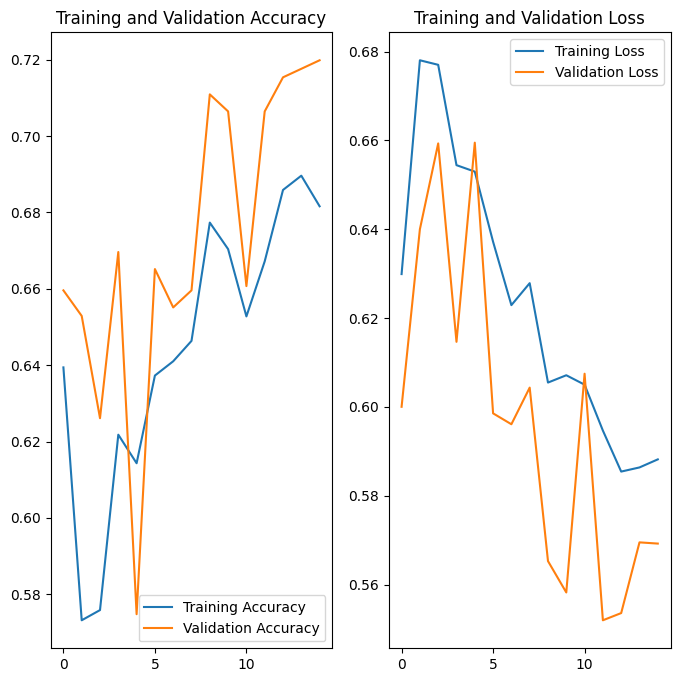

In [ ]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Cell 10**

Now it is time to use your model to predict whether a brand new image is a cat or a dog.

In this cell, get the probability that each test image (from test_data_gen) is a dog or a cat. probabilities should be a list of integers.

Call the plotImages function and pass in the test images and the probabilities corresponding to each test image.

After you run the cell, you should see all 50 test images with a label showing the percentage of "sure" that the image is a cat or a dog. The accuracy will correspond to the accuracy shown in the graph above (after running the previous cell). More training images could lead to a higher accuracy.

1/1 [==============================] - 2s 2s/step


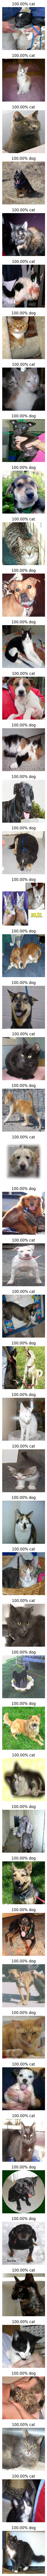

In [ ]:
test_images, _ = next(test_data_gen)
probabilities = np.argmax(model.predict(test_data_gen), axis=-1)
plotImages(test_images, probabilities=probabilities)

**Cell 11**

Run this final cell to see if you passed the challenge or if you need to keep trying.

In [ ]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 68.0% of the images of cats and dogs.
You passed the challenge!
